## Second OPTICS Approach

### Added League Information:

- Used the ginf.csv dataset to map each team to its league.
- Added the league as a separate column for evaluation.

### Fine-Tuned OPTICS Parameters:

- Adjusted min_samples, xi, and min_cluster_size to encourage 5 clusters.
- Explored metrics (silhouette score, ARI, homogeneity) to assess clustering quality.

### Compared Clusters with Leagues:

- Used Adjusted Rand Index (ARI) and Homogeneity Score to evaluate how well the clusters align with league labels.

### Cluster Visualization:

- PCA visualization shows how teams are grouped in 2D space.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Step 1: Load the processed data
file_path = '../data/final_team_cluster_data.csv'
final_team_cluster_data = pd.read_csv(file_path)

In [5]:
# Add league information from the matches dataset
matches_file_path = '../data/ginf.csv'
matches_data = pd.read_csv(matches_file_path)
team_league_map = pd.concat([matches_data[['ht', 'league']], matches_data[['at', 'league']].rename(columns={'at': 'ht'})])
team_league_map = team_league_map.drop_duplicates().set_index('ht')['league'].to_dict()
final_team_cluster_data['league'] = final_team_cluster_data['event_team'].map(team_league_map)

In [6]:
final_team_cluster_data

,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,...,location_17.0_x_assist_method_2,location_17.0_x_assist_method_3,location_17.0_x_assist_method_4,location_18.0_x_assist_method_0,location_18.0_x_assist_method_1,location_18.0_x_assist_method_2,location_18.0_x_assist_method_3,location_18.0_x_assist_method_4,event_team,league
0,-0.715810,-0.610901,0.700009,0.027356,-0.494628,1.486222,0.137229,0.497987,1.867451,1.124688,...,0.561433,0.747806,0.676574,0.761211,0.428062,0.362012,0.483445,0.359857,AC Ajaccio,F1
1,1.547139,1.577442,0.256363,0.485055,0.639721,0.865998,0.441825,0.522511,0.741105,0.205629,...,-0.200648,-0.626439,0.584273,-0.541538,-0.488953,-0.565341,-0.588202,-0.370542,AC Milan,I1
2,0.225299,0.250252,0.957110,0.430974,-0.494628,0.651306,0.239345,0.094254,0.536273,1.436654,...,2.136208,1.521806,3.534141,0.791302,0.515099,0.840586,0.628231,1.388713,AJ Auxerre,F1
3,0.501141,1.059849,0.109136,-0.429150,-0.494628,0.026664,0.507114,0.281674,-0.126643,0.899765,...,-0.402317,-0.698217,-0.298685,0.024781,0.070247,0.205965,-0.087182,0.153934,AS Monaco,F1
4,-0.105813,-0.876846,0.392917,-0.640701,-0.494628,0.459971,-0.506099,0.053324,0.851024,0.554918,...,0.794671,0.980072,1.110654,0.311167,0.432617,0.260407,0.381642,0.360688,AS Nancy Lorraine,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,-0.201986,0.229990,-0.028971,0.352107,-0.030275,-0.925759,0.402729,0.040211,0.985345,0.200347,...,-1.004410,-1.025205,-0.028138,0.149732,0.212285,-0.048390,-0.208312,0.742229,Villarreal,SP1
138,0.023285,-0.347490,0.015995,0.126173,0.828779,0.261678,0.231175,-0.518975,-1.487760,-1.149193,...,0.217961,1.683391,-0.980815,-0.841347,-0.904682,-0.852831,-0.761717,-0.739955,Watford,E0
139,0.529992,0.151757,0.761776,-0.103338,-0.494628,-0.156822,-0.031944,0.881133,0.110186,0.121506,...,-0.411878,0.064096,-0.726382,0.160426,0.189034,0.093470,0.400555,-0.225737,Werder Bremen,D1
140,-2.089548,-1.901963,-2.089648,-1.563744,-0.494628,-0.955515,-2.222988,-2.130656,-1.890805,-1.755596,...,-1.153840,-0.943130,-1.024525,-0.561233,-0.572263,-0.492085,-0.404457,-0.480067,West Brom,E0


In [8]:
# Verify that league column was added correctly
final_team_cluster_data['league'].unique()

array(['F1', 'I1', 'SP1', 'E0', 'D1'], dtype=object)

In [9]:
# Print all event_team from league 'F1'
final_team_cluster_data[final_team_cluster_data['league'] == 'F1']['event_team'].unique()

array(['AC Ajaccio', 'AJ Auxerre', 'AS Monaco', 'AS Nancy Lorraine',
       'Angers', 'Bastia', 'Bordeaux', 'Brest', 'Caen', 'Dijon FCO',
       'Evian Thonon Gaillard', 'GFC Ajaccio', 'Guingamp', 'Lens',
       'Lille', 'Lorient', 'Lyon', 'Marseille', 'Metz', 'Montpellier',
       'Nantes', 'Nice', 'Paris Saint-Germain', 'Sochaux', 'St Etienne',
       'Stade Rennes', 'Stade de Reims', 'Toulouse', 'Troyes',
       'Valenciennes'], dtype=object)

In [10]:
# Step 2: Prepare data for clustering
# Drop the team name and league columns to use only features
team_names = final_team_cluster_data['event_team']
league_labels = final_team_cluster_data['league']  # Use this later for evaluation
clustering_features = final_team_cluster_data.drop(columns=['event_team', 'league'])

In [11]:
# Step 3: Apply OPTICS Clustering
# Configure OPTICS with fine-tuned parameters
optics_model = OPTICS(min_samples=5, metric='euclidean', cluster_method='xi', xi=0.05, min_cluster_size=0.1)
optics_model.fit(clustering_features)

OPTICS(metric='euclidean', min_cluster_size=0.1)

In [12]:
# Extract cluster labels
final_team_cluster_data['cluster'] = optics_model.labels_

In [13]:
# Step 4: Evaluate Clustering Results
# Compute silhouette score
if len(set(optics_model.labels_)) > 1:
    silhouette = silhouette_score(clustering_features, optics_model.labels_)
    print(f"Silhouette Score: {silhouette:.2f}")
else:
    print("Silhouette Score: Cannot compute (only one cluster)")

Silhouette Score: 0.35


In [14]:
# Compare clusters with league labels
# Adjusted Rand Index (ARI) and Homogeneity Score
ari = adjusted_rand_score(league_labels, optics_model.labels_)
homogeneity = homogeneity_score(league_labels, optics_model.labels_)
print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Homogeneity Score: {homogeneity:.2f}")

Adjusted Rand Index (ARI): 0.10
Homogeneity Score: 0.18


In [15]:
# Cluster size distribution
cluster_counts = pd.Series(optics_model.labels_).value_counts()
print("\nCluster Size Distribution:")
print(cluster_counts)


Cluster Size Distribution:
-1    123
 0     19
Name: count, dtype: int64


In [16]:
# Step 5: Visualize Clusters with PCA
# Use PCA for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(clustering_features)

In [17]:
# Add PCA components to the DataFrame
final_team_cluster_data['pca_x'] = pca_features[:, 0]
final_team_cluster_data['pca_y'] = pca_features[:, 1]

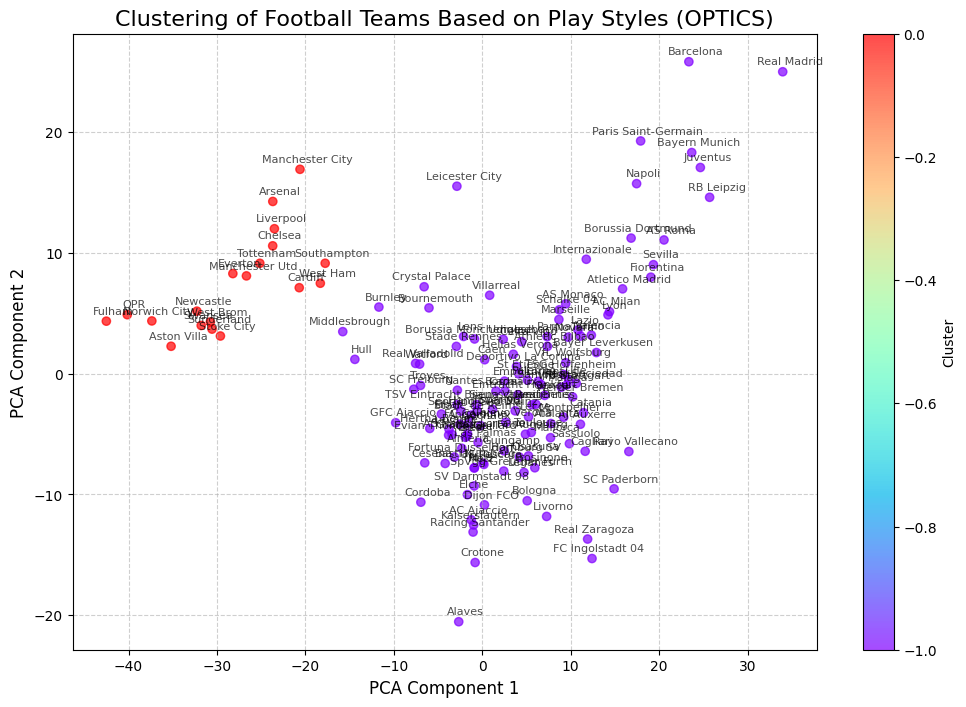

In [23]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_team_cluster_data['pca_x'], 
    final_team_cluster_data['pca_y'], 
    c=final_team_cluster_data['cluster'], 
    cmap='rainbow', 
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering of Football Teams Based on Play Styles (OPTICS)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Annotate team names
for i, team in enumerate(team_names):
    plt.annotate(
        team,
        (final_team_cluster_data['pca_x'][i], final_team_cluster_data['pca_y'][i]),
        fontsize=8,
        alpha=0.7,
        textcoords="offset points",
        xytext=(5, 5),
        ha='center'
    )
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()